# nb-model_exp-neural-process

In [2]:
import sys
import os
from os import sep
from os.path import dirname, realpath, exists
from pathlib import Path
from functools import partial
import random
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which is why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fname = 'nb-model_exp-neural-process.ipynb'
dir_name = 'model'
fix_path(get_cwd(fname, dir_name +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
from verification.batch_norm import BatchNormVerificationCallback
from verification.batch_gradient import BatchGradientVerificationCallback

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 50)

from common_util import MODEL_DIR, load_json, dump_json, rectify_json, load_df, str_now, makedir_if_not_exists, is_valid, isnt, compose, pd_split_ternary_to_binary, df_del_midx_level, midx_intersect, pd_get_midx_level, pd_rows, df_midx_restack
from common_util import NestedDefaultDict
from model.common import EXP_LOG_DIR, EXP_PARAMS_DIR, ASSETS, DATASET_DIR, XG_PROCESS_DIR, XG_DATA_DIR, XG_DIR, PYTORCH_MODELS_DIR, TRAIN_RATIO, EXPECTED_NUM_HOURS
from model.pl_xgdm import XGDataModule
from model.pl_np import NPModel
from model.np_util2 import AttentiveNP
from recon.viz import *
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

CRITICAL:root:script location: /home/kev/crunch/model/nb-model_exp-neural-process.ipynb
CRITICAL:root:using project dir: /home/kev/crunch/


Prune the xg data down to the data of interest to use in further experiments.

In [3]:
%autoreload 1
%aimport model.np_util2, model.train_util, model.pl_np, model.pl_generic, model.metrics_util, model.model_util, model.pl_xgdm

In [4]:
# s=0
# torch.manual_seed(s)
# random.seed(s)
# np.random.seed(s)

In [5]:
torch.seed()

7829394646354107227

In [5]:
model_name = 'anp'
asset_name = ASSETS[0]
dsubs = 'h'
fdata_name = f'h_pba_{dsubs}' # hpomzug
ldata_name = 'ddir' 
loss_type = 'clf-ce'
model_type = loss_type.split('-')[0]

# monitor = 'val_f1.0' if (model_type == 'clf') else 'val_mae'
monitor = 'val_accuracy' if (model_type == 'clf') else 'val_mae'
num_classes = 2 if (model_type == 'clf') else None

optimize_dir = {
    'val_loss': 'minimize',
    'val_mae': 'minimize',
    'val_mse': 'minimize'
}.get(monitor, 'maximize')

pl_model_fn, pt_model_fn = NPModel, AttentiveNP
model_name = f'{model_type}_{pl_model_fn.__name__}_{pt_model_fn.__name__}'
logging.getLogger("lightning").setLevel(logging.ERROR)
print('cuda status: {}'.format('✓' if (torch.cuda.is_available()) else '🞩'))

cuda status: ✓


## 4 Assets X {CNP, LNP, NP, X}

In [6]:
np_type = 'np' # base, cnp, lnp, np
exp_dir = MODEL_DIR +sep.join(['exp-log', asset_name, np_type]) +sep

In [7]:
t_params_common = load_json('params_t.json', MODEL_DIR +sep.join(['exp-log']))
t_params_asset = load_json('params_t.json', MODEL_DIR +sep.join(['exp-log', asset_name]))
t_params = {**t_params_common, **t_params_asset}

m_params_common = load_json('params_m.json', MODEL_DIR +sep.join(['exp-log']))
m_params_asset = load_json('params_m.json', MODEL_DIR +sep.join(['exp-log', asset_name]))
m_params_exp = load_json('params_m.json', MODEL_DIR +sep.join(['exp-log', asset_name, np_type]))

m_params = {**m_params_common, **m_params_asset, **m_params_exp}

In [8]:
#m_params

In [9]:
#t_params

In [10]:
fret=None
dm = XGDataModule(t_params, asset_name, fdata_name, ldata_name, interval=(1996, 2018), fret=None,
                  overwrite_cache=False)
dm.prepare_data()
dm.setup()

mdl = pl_model_fn(pt_model_fn, m_params, t_params, dm.fobs)

In [11]:
#m_params

In [12]:
#t_params

In [13]:
#mdl

## Experiment

In [14]:
trial_time = str_now().replace(' ', '_').replace(':', '-')
study_dir = exp_dir +sep.join(['anp', model_name, dm.name]) +sep
trial_dir = f'{study_dir}{trial_time}{sep}'
makedir_if_not_exists(trial_dir)
dump_json(rectify_json(m_params), 'params_m.json', trial_dir)
dump_json(rectify_json(t_params), 'params_t.json', trial_dir)
max_epochs = t_params['epochs']
min_epochs = max_epochs // 4

csv_log = pl.loggers.csv_logs.CSVLogger(trial_dir, name='', version='')
tb_log = pl.loggers.tensorboard.TensorBoardLogger(trial_dir, name='', \
    version='', log_graph=False)
chk_callback = pl.callbacks.ModelCheckpoint(f'{trial_dir}chk{sep}', \
    monitor=monitor, mode=optimize_dir[:3])
es_callbacks = (EarlyStopping(monitor=monitor, min_delta=0.00, patience=0,
                            verbose=False, mode=optimize_dir[:3]),)
# ver_callbacks = (BatchNormVerificationCallback(), \
#                 BatchGradientVerificationCallback())
ver_callbacks = ()
# es_callbacks = ()
gd_callbacks = () #(GraphDumpCallback(),)

trainer = pl.Trainer(max_epochs=max_epochs, min_epochs=min_epochs, logger=[csv_log, tb_log],
            callbacks=[chk_callback, *es_callbacks, *ver_callbacks],
            limit_val_batches=1.0, gradient_clip_val=0, gradient_clip_algorithm='norm',
            stochastic_weight_avg=False, auto_lr_find=False, #track_grad_norm=2,
            amp_level='O1', precision=mdl.get_precision(),
            default_root_dir=trial_dir, weights_summary=None,
            gpus=-1 if (torch.cuda.is_available()) else None)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.


In [15]:
bench_fname = 'benchmark.json'
if (not exists('{study_dir}{bench_fname}')):
    bench_final = dm.get_benchmarks_json()
    dump_json(bench_final, bench_fname, study_dir)
bench = dm.get_benchmarks()

AttributeError: 'XGDataModule' object has no attribute 'get_benchmarks_json'

In [16]:
trainer.fit(mdl, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Experiment logs directory /home/kev/crunch/model/exp-log/sp_500/np/anp/clf_NPModel_AttentiveNP/1996_2018_ddir_h_pba_h/2021-07-19_17-36-56/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/kev/miniconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (25) or minimum steps (None) has not been met. Training will continue...


Validating: 0it [00:00, ?it/s]

## Benchmarks vs Results

In [24]:
trainer.validate(mdl, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'epoch': 24.0,
 'val_accuracy': 0.5503048896789551,
 'val_binary_cagr': 0.1817624568939209,
 'val_binary_max': 1.3857091665267944,
 'val_binary_min': -0.002049737609922886,
 'val_binary_profit': 1.3857091665267944,
 'val_binary_sharpe': 1.3301215171813965,
 'val_binary_skew': 0.30652350187301636,
 'val_conf_cagr': 0.13100647926330566,
 'val_conf_max': 0.8982699513435364,
 'val_conf_min': -0.0006738852825947106,
 'val_conf_profit': 0.8982699513435364,
 'val_conf_sharpe': 1.3834881782531738,
 'val_conf_skew': 0.5602757334709167,
 'val_f1.0': 0.5495973825454712,
 'val_kelly_cagr': 0.06834149360656738,
 'val_kelly_max': 0.4108307957649231,
 'val_kelly_min': -0.0023960380349308252,
 'val_kelly_profit': 0.4108307957649231,
 'val_kelly_sharpe': 1.5215427875518799,
 'val_kelly_skew': 1.4430829286575317,
 'val_loss': 0.6873099207878113,
 'val_precision': 0.5504308342933655,
 'val_reca

[{'epoch': 24.0,
  'val_loss': 0.6873099207878113,
  'val_accuracy': 0.5503048896789551,
  'val_precision': 0.5504308342933655,
  'val_recall': 0.5507743954658508,
  'val_f1.0': 0.5495973825454712,
  'val_binary_min': -0.002049737609922886,
  'val_binary_max': 1.3857091665267944,
  'val_binary_profit': 1.3857091665267944,
  'val_binary_cagr': 0.1817624568939209,
  'val_binary_sharpe': 1.3301215171813965,
  'val_binary_skew': 0.30652350187301636,
  'val_conf_min': -0.0006738852825947106,
  'val_conf_max': 0.8982699513435364,
  'val_conf_profit': 0.8982699513435364,
  'val_conf_cagr': 0.13100647926330566,
  'val_conf_sharpe': 1.3834881782531738,
  'val_conf_skew': 0.5602757334709167,
  'val_kelly_min': -0.0023960380349308252,
  'val_kelly_max': 0.4108307957649231,
  'val_kelly_profit': 0.4108307957649231,
  'val_kelly_cagr': 0.06834149360656738,
  'val_kelly_sharpe': 1.5215427875518799,
  'val_kelly_skew': 1.4430829286575317}]

(<Figure size 1800x1800 with 3 Axes>,
 array([<AxesSubplot:title={'center':'train np-binary cumulative profit and loss (PnL)'}, ylabel='cumulative PnL'>,
        <AxesSubplot:title={'center':'train np-binary returns'}, xlabel='train examples', ylabel='return'>,
        <AxesSubplot:title={'center':'train np-binary distribution'}, xlabel='train return', ylabel='frequency'>],
       dtype=object))

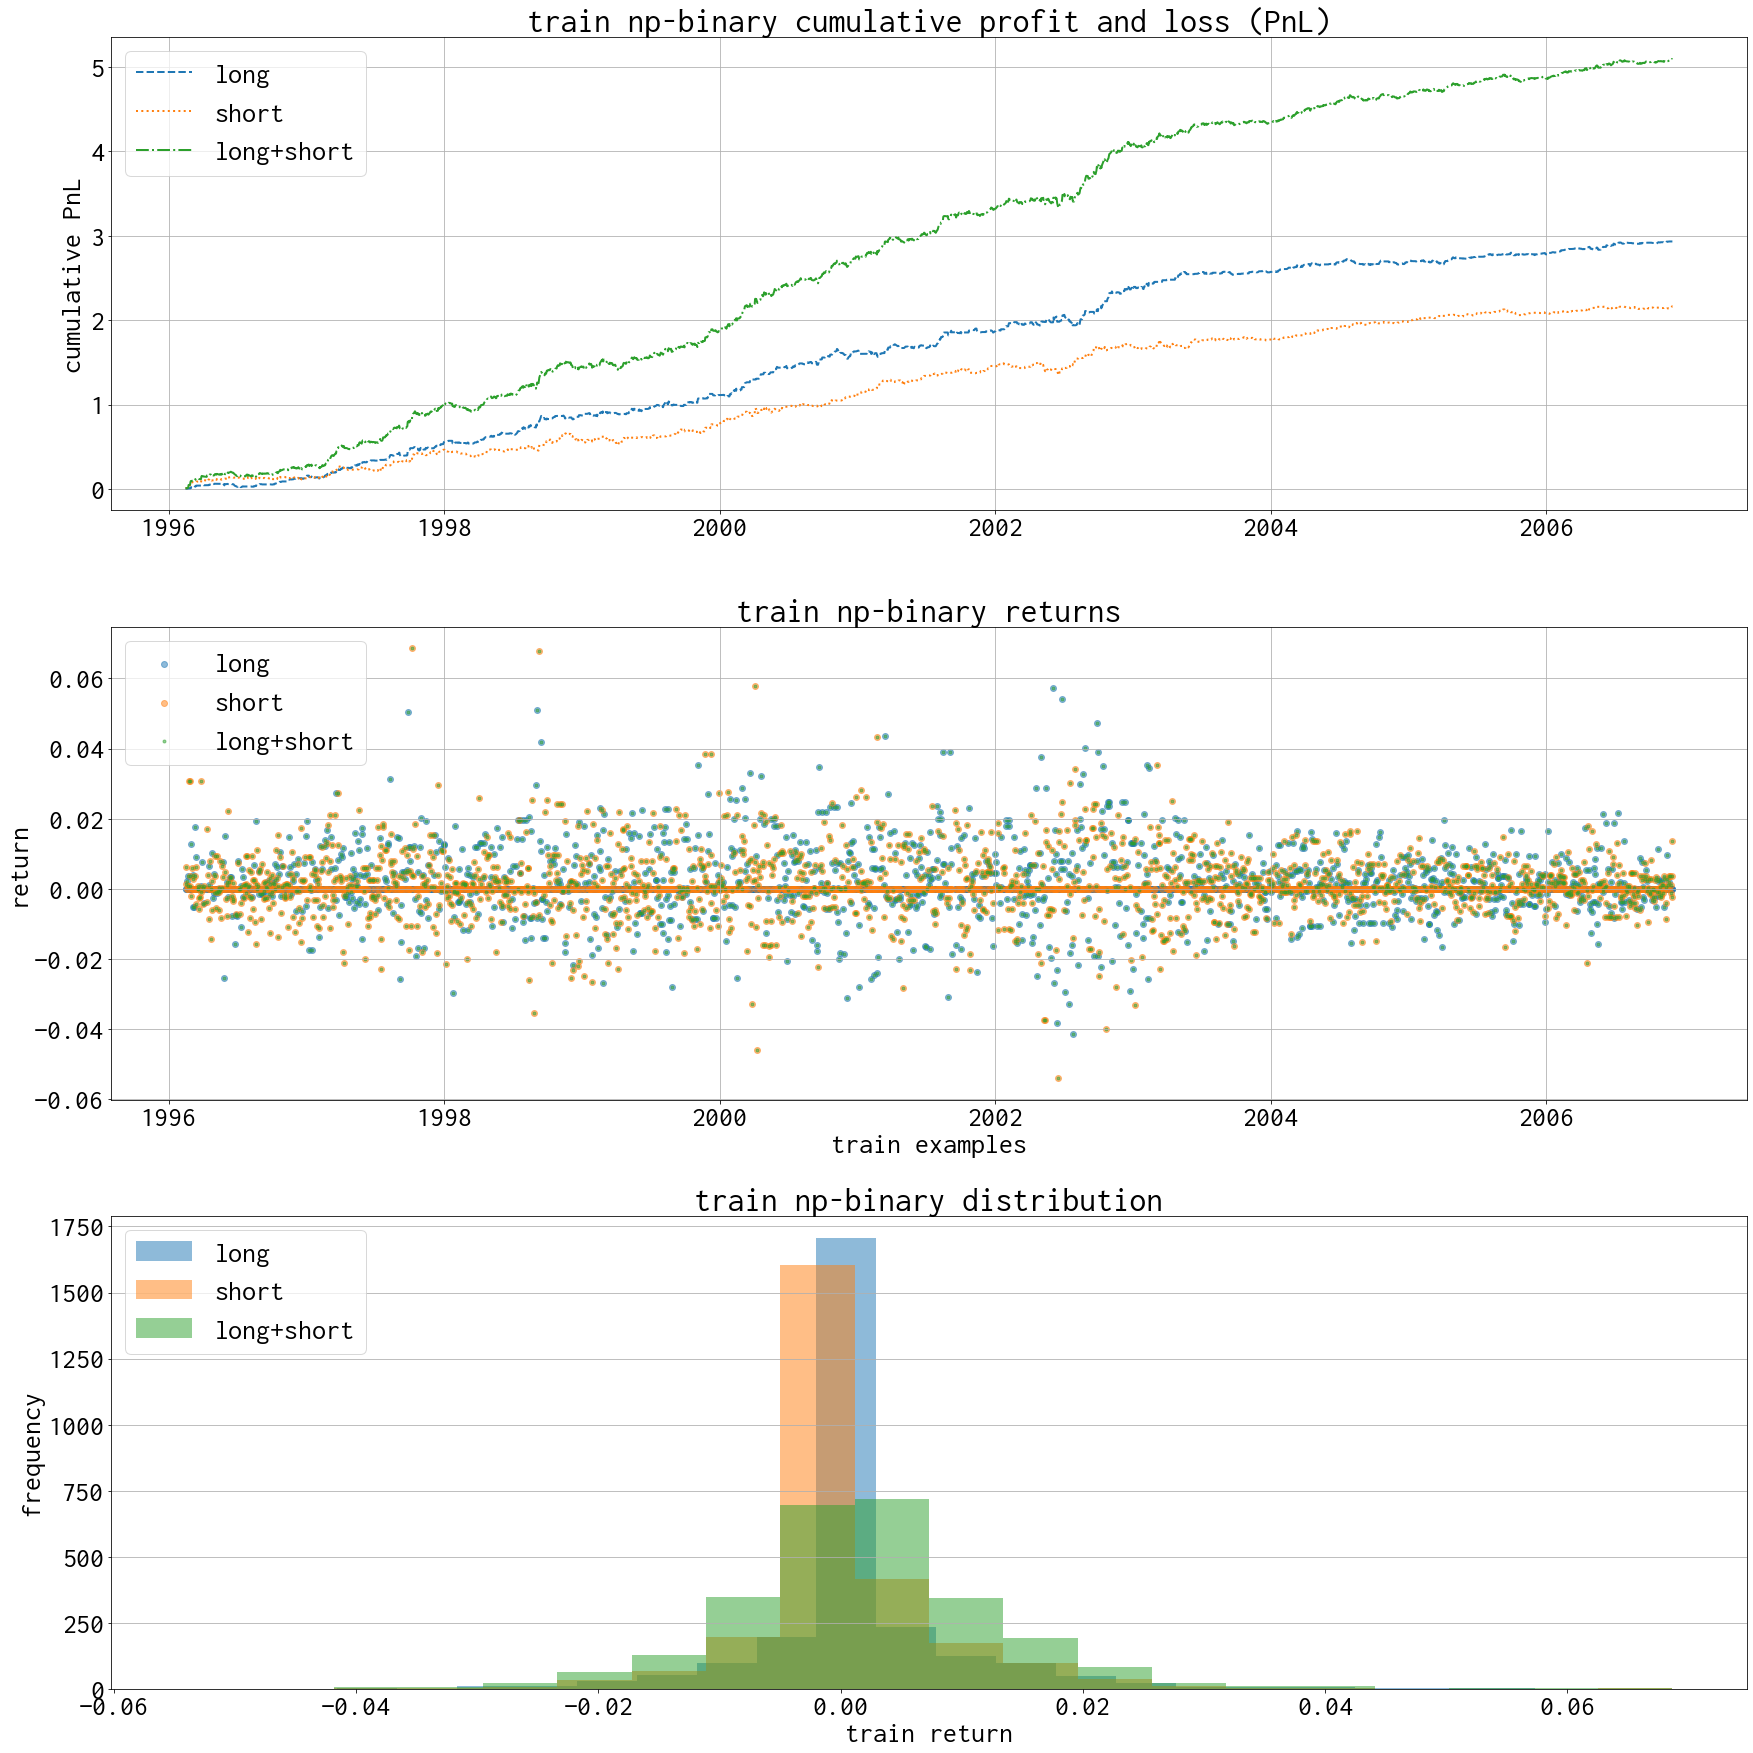

In [20]:
mdl.epoch_returns['train']['binary'].plot_result_series('train', 'np-binary', dm.idx['train'])

(<Figure size 1800x1800 with 3 Axes>,
 array([<AxesSubplot:title={'center':'val np-binary cumulative profit and loss (PnL)'}, ylabel='cumulative PnL'>,
        <AxesSubplot:title={'center':'val np-binary returns'}, xlabel='val examples', ylabel='return'>,
        <AxesSubplot:title={'center':'val np-binary distribution'}, xlabel='val return', ylabel='frequency'>],
       dtype=object))

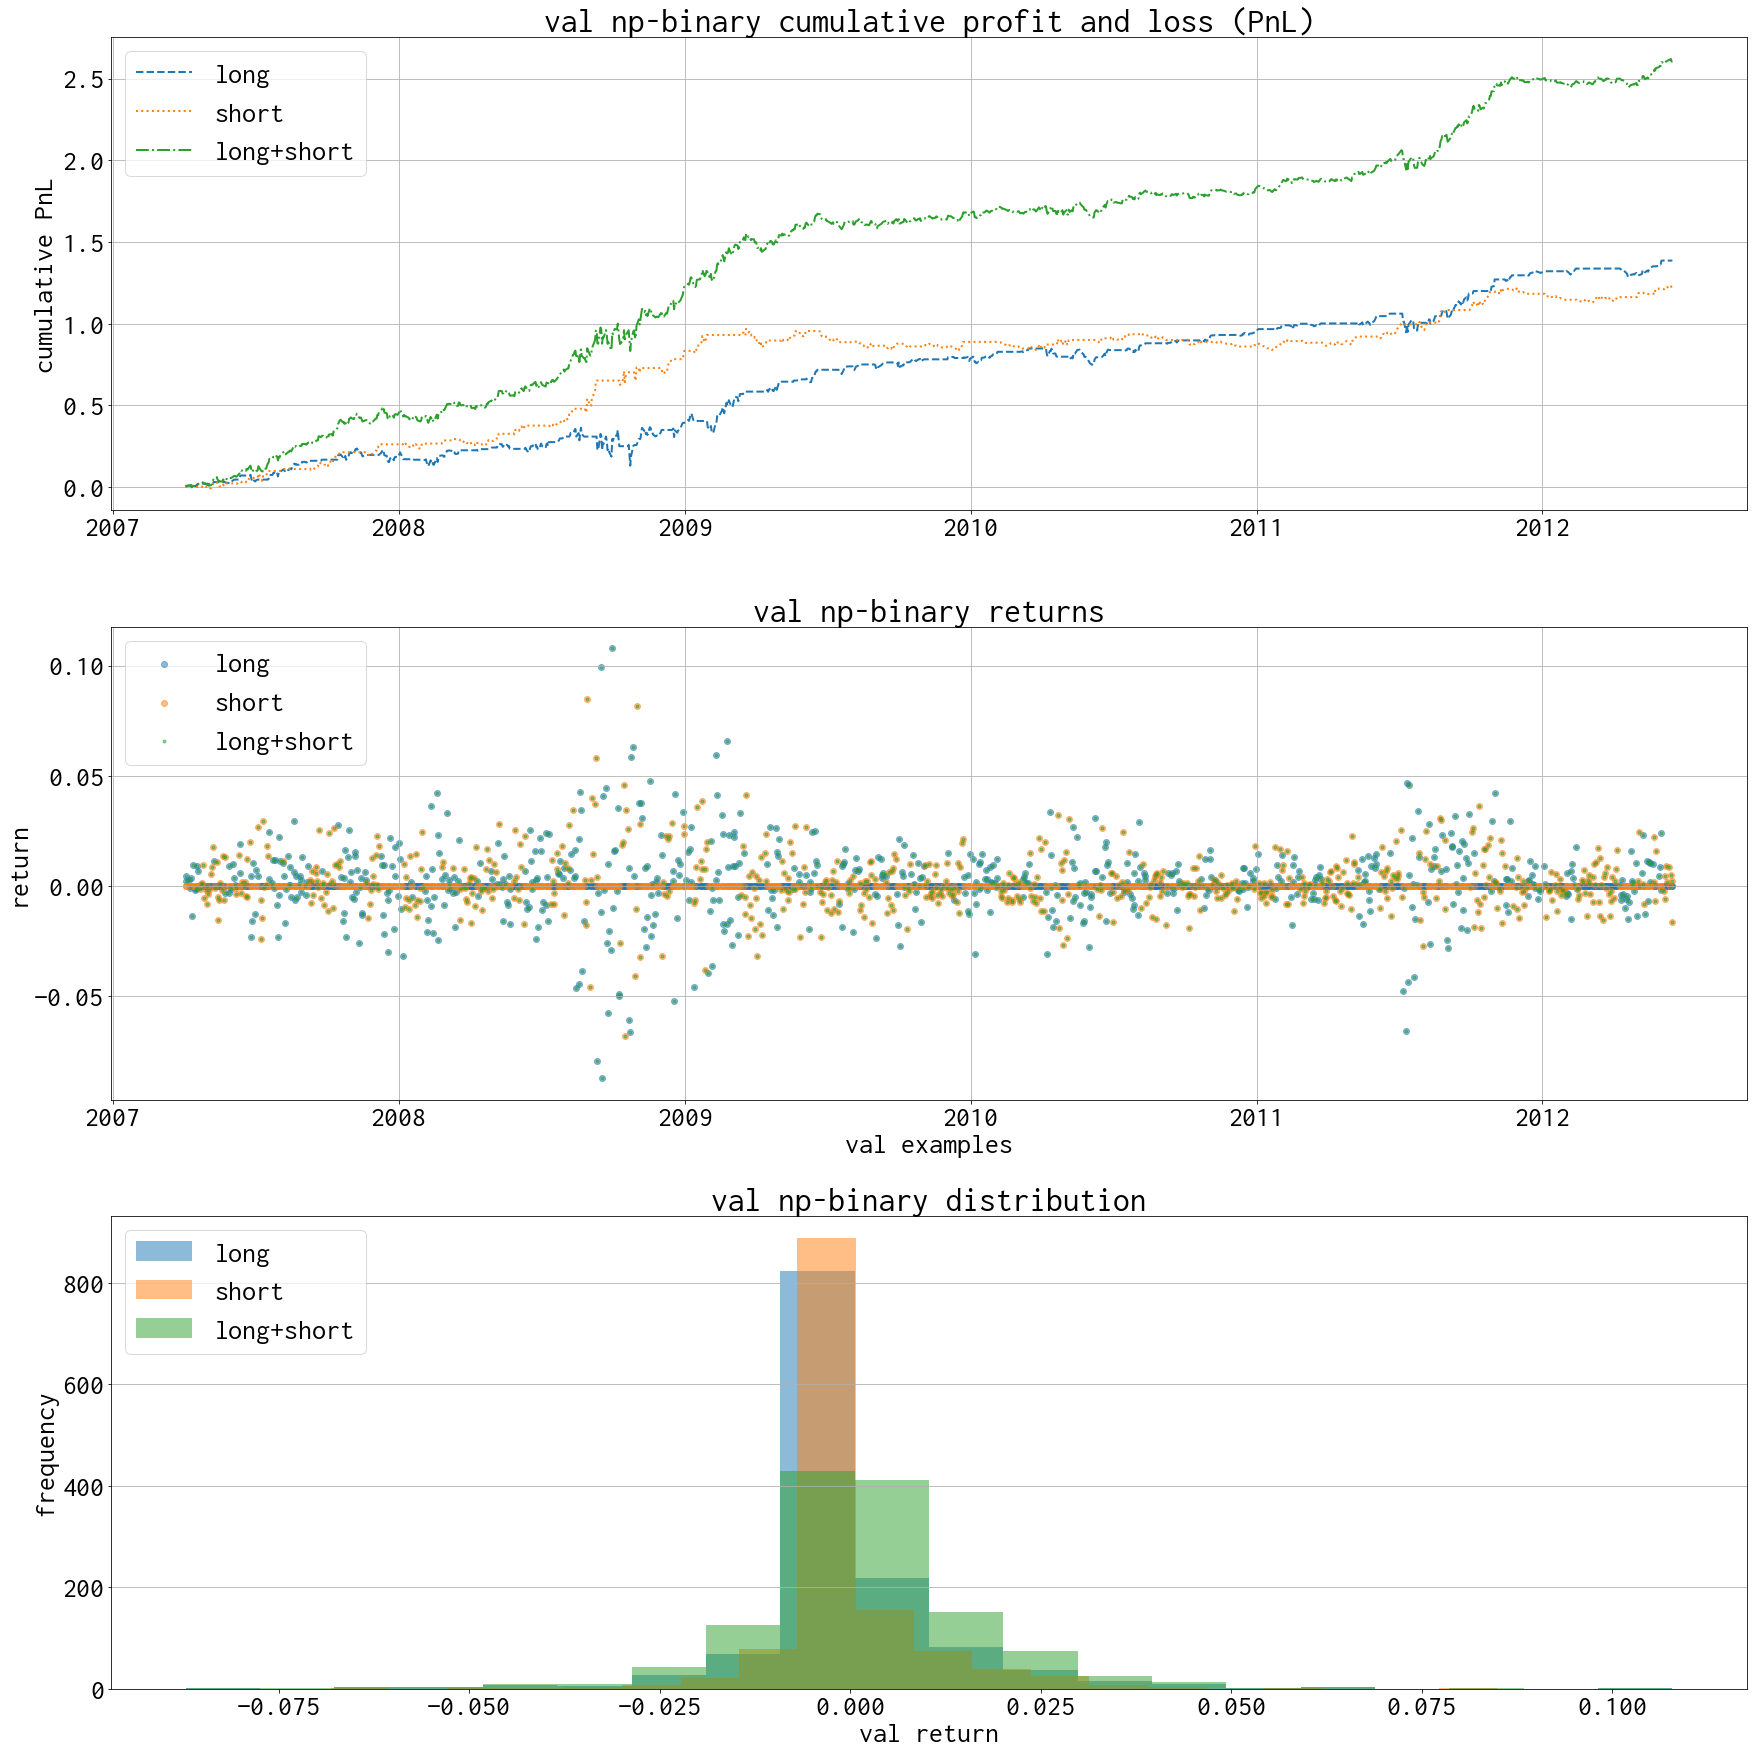

In [19]:
mdl.epoch_returns['val']['binary'].plot_result_series('val', 'np-binary', dm.idx['val'])

In [27]:
mdl.epoch_metrics['train']

{'accuracy': Accuracy(),
 'precision': Precision(),
 'recall': Recall(),
 'f1.0': FBeta()}

In [21]:
# dm.idx; #Indices used for inference (target indices)
# bench; #benchmark objects and label distributions

In [91]:
#raw_ret = {}
bench_strats = NestedDefaultDict()
mdl_strats = NestedDefaultDict()

for split in ('train', 'val'):
    tt = dm.raw[split][2]
    tt = tt[tt!=0]
    index=dm.idx[split]
    #raw_ret[split] = pd.DataFrame(tt[dm.start[split]:dm.end[split]], columns=[f'{split}_raw_returns'], index=index)
    
    # Benchmark strategy
    for strat in ('bh', 'bo'):
        r = pd.DataFrame({
            f'long': bench[split]['strat'][strat].compute_returns(go_long=True, go_short=False),
            f'short': bench[split]['strat'][strat].compute_returns(go_long=False, go_short=True)},
            index=index)
        cr = pd.DataFrame({
            f'long': bench[split]['strat'][strat].compute_cumrets(go_long=True, go_short=False),
            f'short': bench[split]['strat'][strat].compute_cumrets(go_long=False, go_short=True)},
            index=index)
        if (strat in ('bo',)):
            r[f'long+short'] = bench[split]['strat'][strat].compute_returns(go_long=True, go_short=True)
            cr[f'long+short'] = bench[split]['strat'][strat].compute_cumrets(go_long=True, go_short=True)
        bench_strats[[split, strat, 'r']] = r
        bench_strats[[split, strat, 'cr']] = cr

    # Model strategy simulated returns
    for strat in ('sb', 'sc', 'sk'):
        r = pd.DataFrame({
            'long': mdl.epoch_returns[split][strat].compute_returns(go_long=True, go_short=False),
            'short': mdl.epoch_returns[split][strat].compute_returns(go_long=False, go_short=True),
            'long+short': mdl.epoch_returns[split][strat].compute_returns(go_long=True, go_short=True)},
            index=index)
        cr = pd.DataFrame({
            'long': mdl.epoch_returns[split][strat].compute_cumrets(go_long=True, go_short=False),
            'short': mdl.epoch_returns[split][strat].compute_cumrets(go_long=False, go_short=True),
            'long+short': mdl.epoch_returns[split][strat].compute_cumrets(go_long=True, go_short=True)},
            index=index)
        mdl_strats[[split, strat, 'r']] = r
        mdl_strats[[split, strat, 'cr']] = cr

#list(bench_strats.keys())

In [28]:
val_sb_longfreq = [len(p[p==1])/len(p) for p in mdl.epoch_returns['val']['binary'].pred_dir]
print(val_sb_longfreq[:5], val_sb_longfreq[-5:]) # make sure both directions are predicted

[0.40625, 0.53125, 0.6875, 0.4375, 0.71875] [0.34375, 0.46875, 0.34375, 0.53125, 0.4375]


In [53]:
torch.mean(torch.tensor(1.))

tensor(1.)

In [55]:
torch.cat(mdl.epoch_returns['val']['binary'].pred_dir)

tensor([ 1.,  1.,  1.,  ..., -1., -1., -1.])

In [48]:
torch.cat(mdl.epoch_returns['train']['binary'].pred_dir).mean()

tensor(-0.0945)

In [43]:
torch.cat(mdl.epoch_returns['val']['conf'].bet_size).mean()

tensor(0.5929)

In [ ]:
val_sb_longfreq = [len(p[p==1])/len(p) for p in mdl.epoch_returns['val']['binary'].pred_dir]

In [95]:
def plot_bench_results(bench_strats, split, strat_name, subset=['long']):
    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(25, 25))
    bench_df = bench_strats[[split, strat_name, 'cr']][subset]
    ret_df = bench_strats[[split, strat_name, 'r']][subset]

    plot_df_line_subplot(bench_df, axes[0], title=f'{split} {strat_name} benchmark (no overnight risk)',
        ylabel='cumulative PnL', colors='k')
    plot_df_scatter_subplot(ret_df, axes[1], title=f'{split} {strat_name} returns', xlabel=f'{split} examples',
        ylabel='return', colors='k')
    plot_df_hist_subplot(ret_df, axes[2], title=f'{split} {strat_name} distribution', xlabel=f'{split} returns',
        ylabel='frequency', colors='k', hist_bins=80)
    fig.tight_layout()

def plot_mdl_results(mdl_strats, split, strat_name, mdl_type, subset=['long', 'short', 'long+short']):
    fig, axes = plt.subplots(3, 1, sharex=False, figsize=(25, 25))
    mdl_df = mdl_strats[[split, strat_name, 'cr']][subset]
    ret_df = mdl_strats[[split, strat_name, 'r']][subset]

    plot_df_line_subplot(mdl_df, axes[0], title=f'{split} {mdl_type} {strat_name} model (no overnight risk)',
        ylabel='cumulative PnL', linestyles=['dashed', 'dotted', 'dashdot'])
    plot_df_scatter_subplot(ret_df, axes[1], title=f'{split} {mdl_type} {strat_name} returns', xlabel=f'{split} examples',
        ylabel='return', alpha=.5, markers=['o', 'o', '.'])
    plot_df_hist_subplot(ret_df, axes[2], title=f'{split} {mdl_type} {strat_name} distribution', xlabel=f'{split} return',
        ylabel='frequency', alpha=.5, hist_bins=20)
    fig.tight_layout()

long    0.017883
dtype: float32
long   -0.107156
dtype: float32


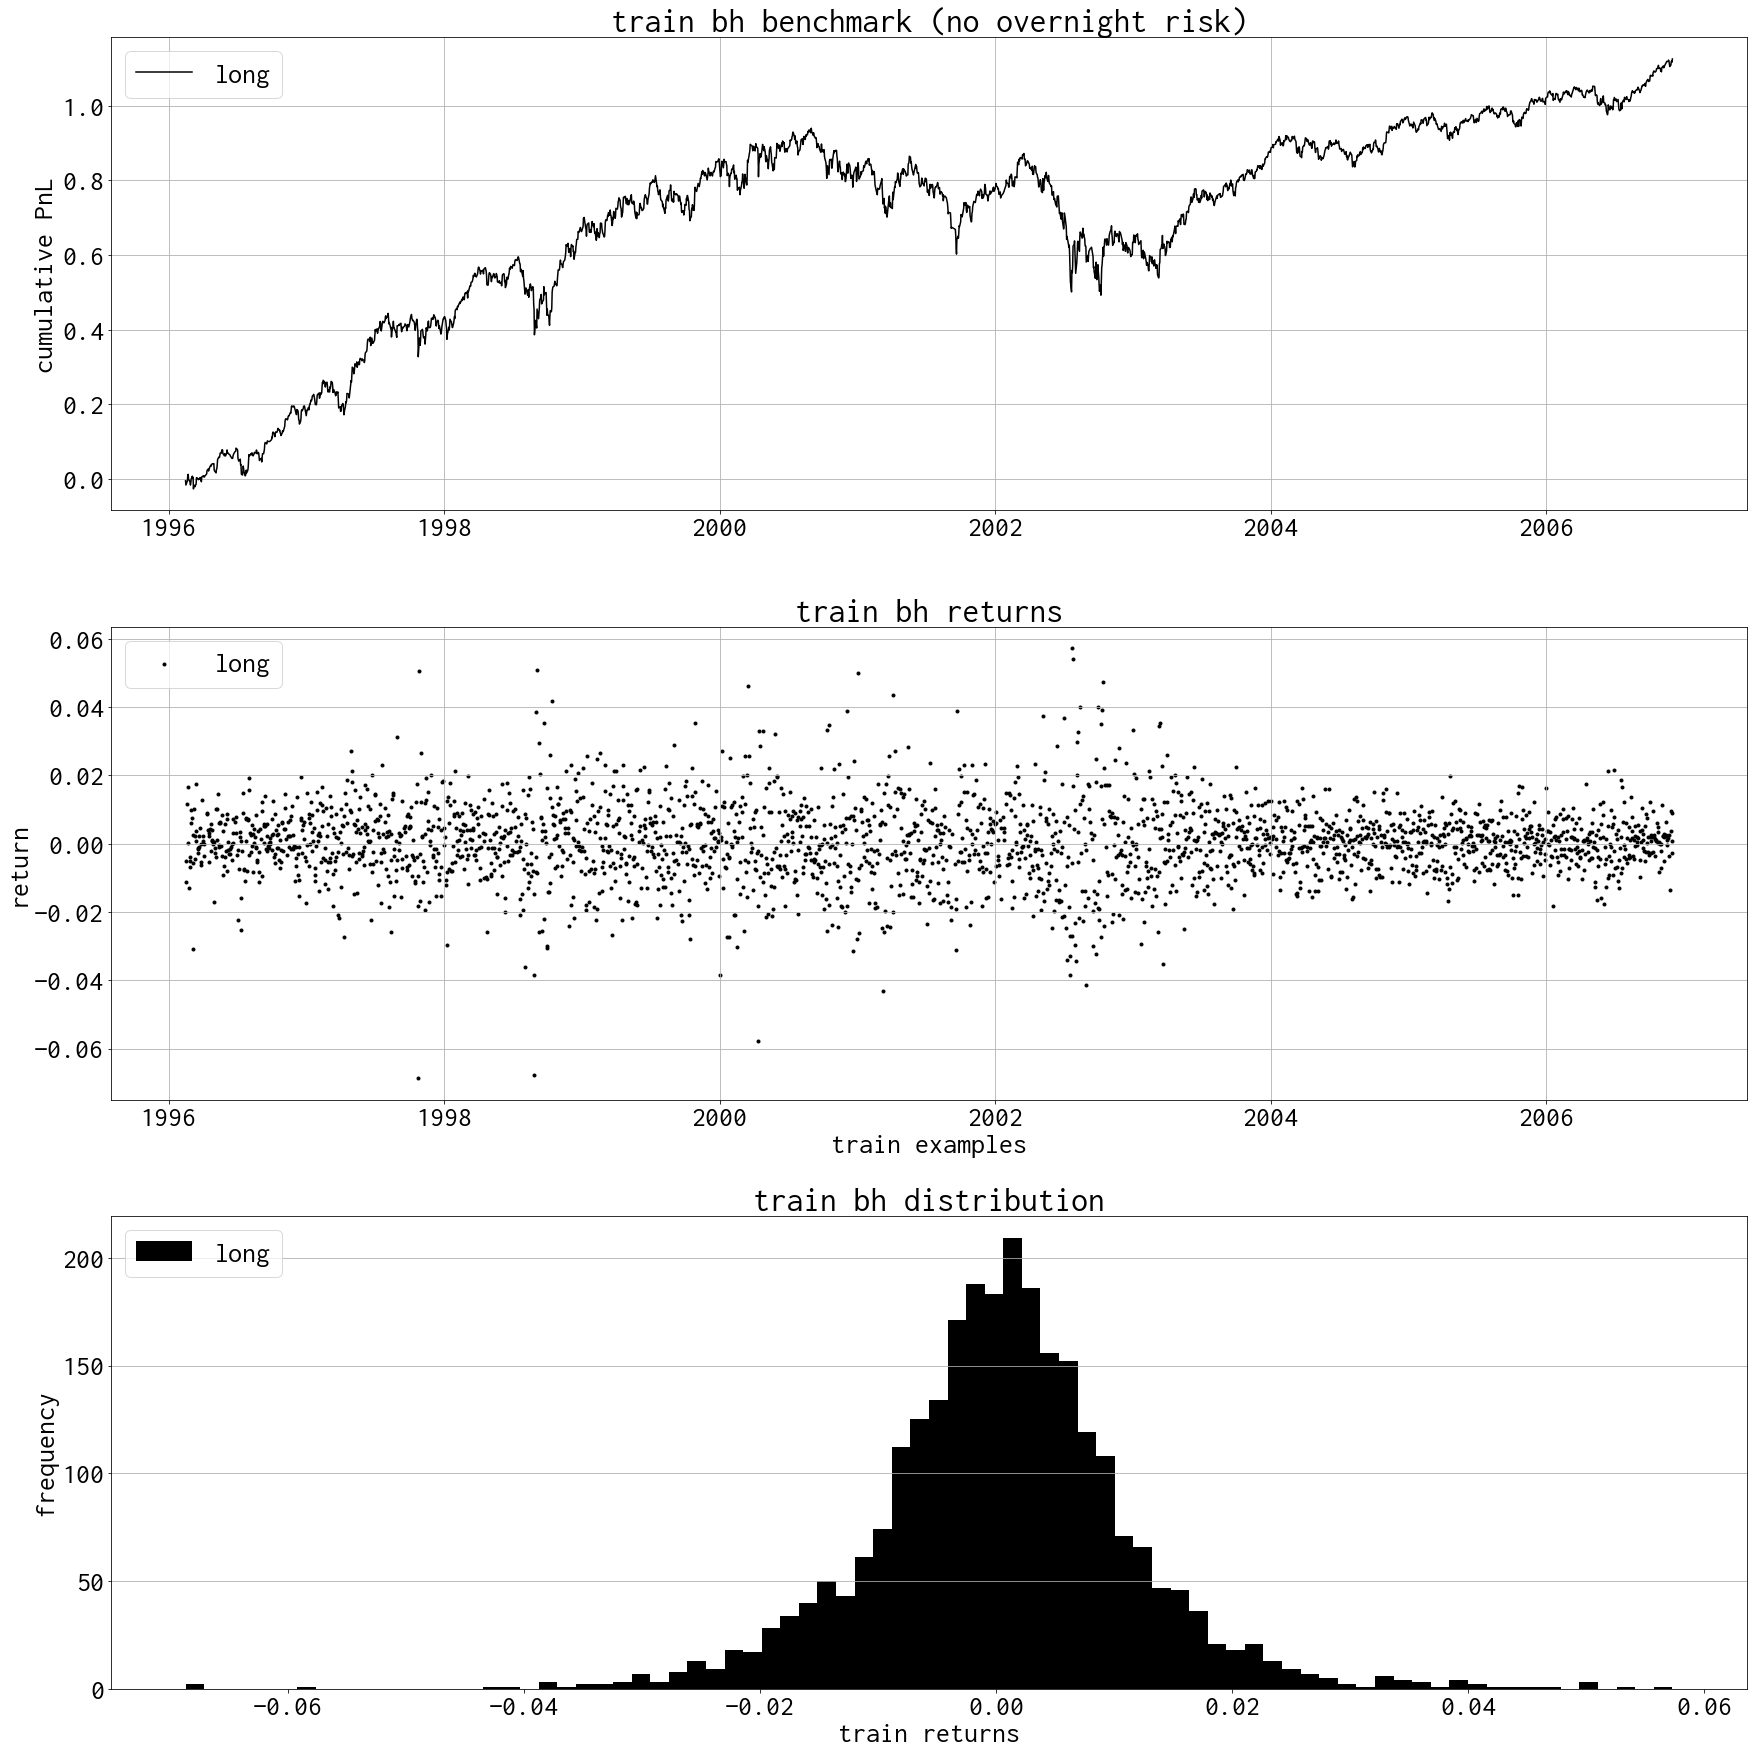

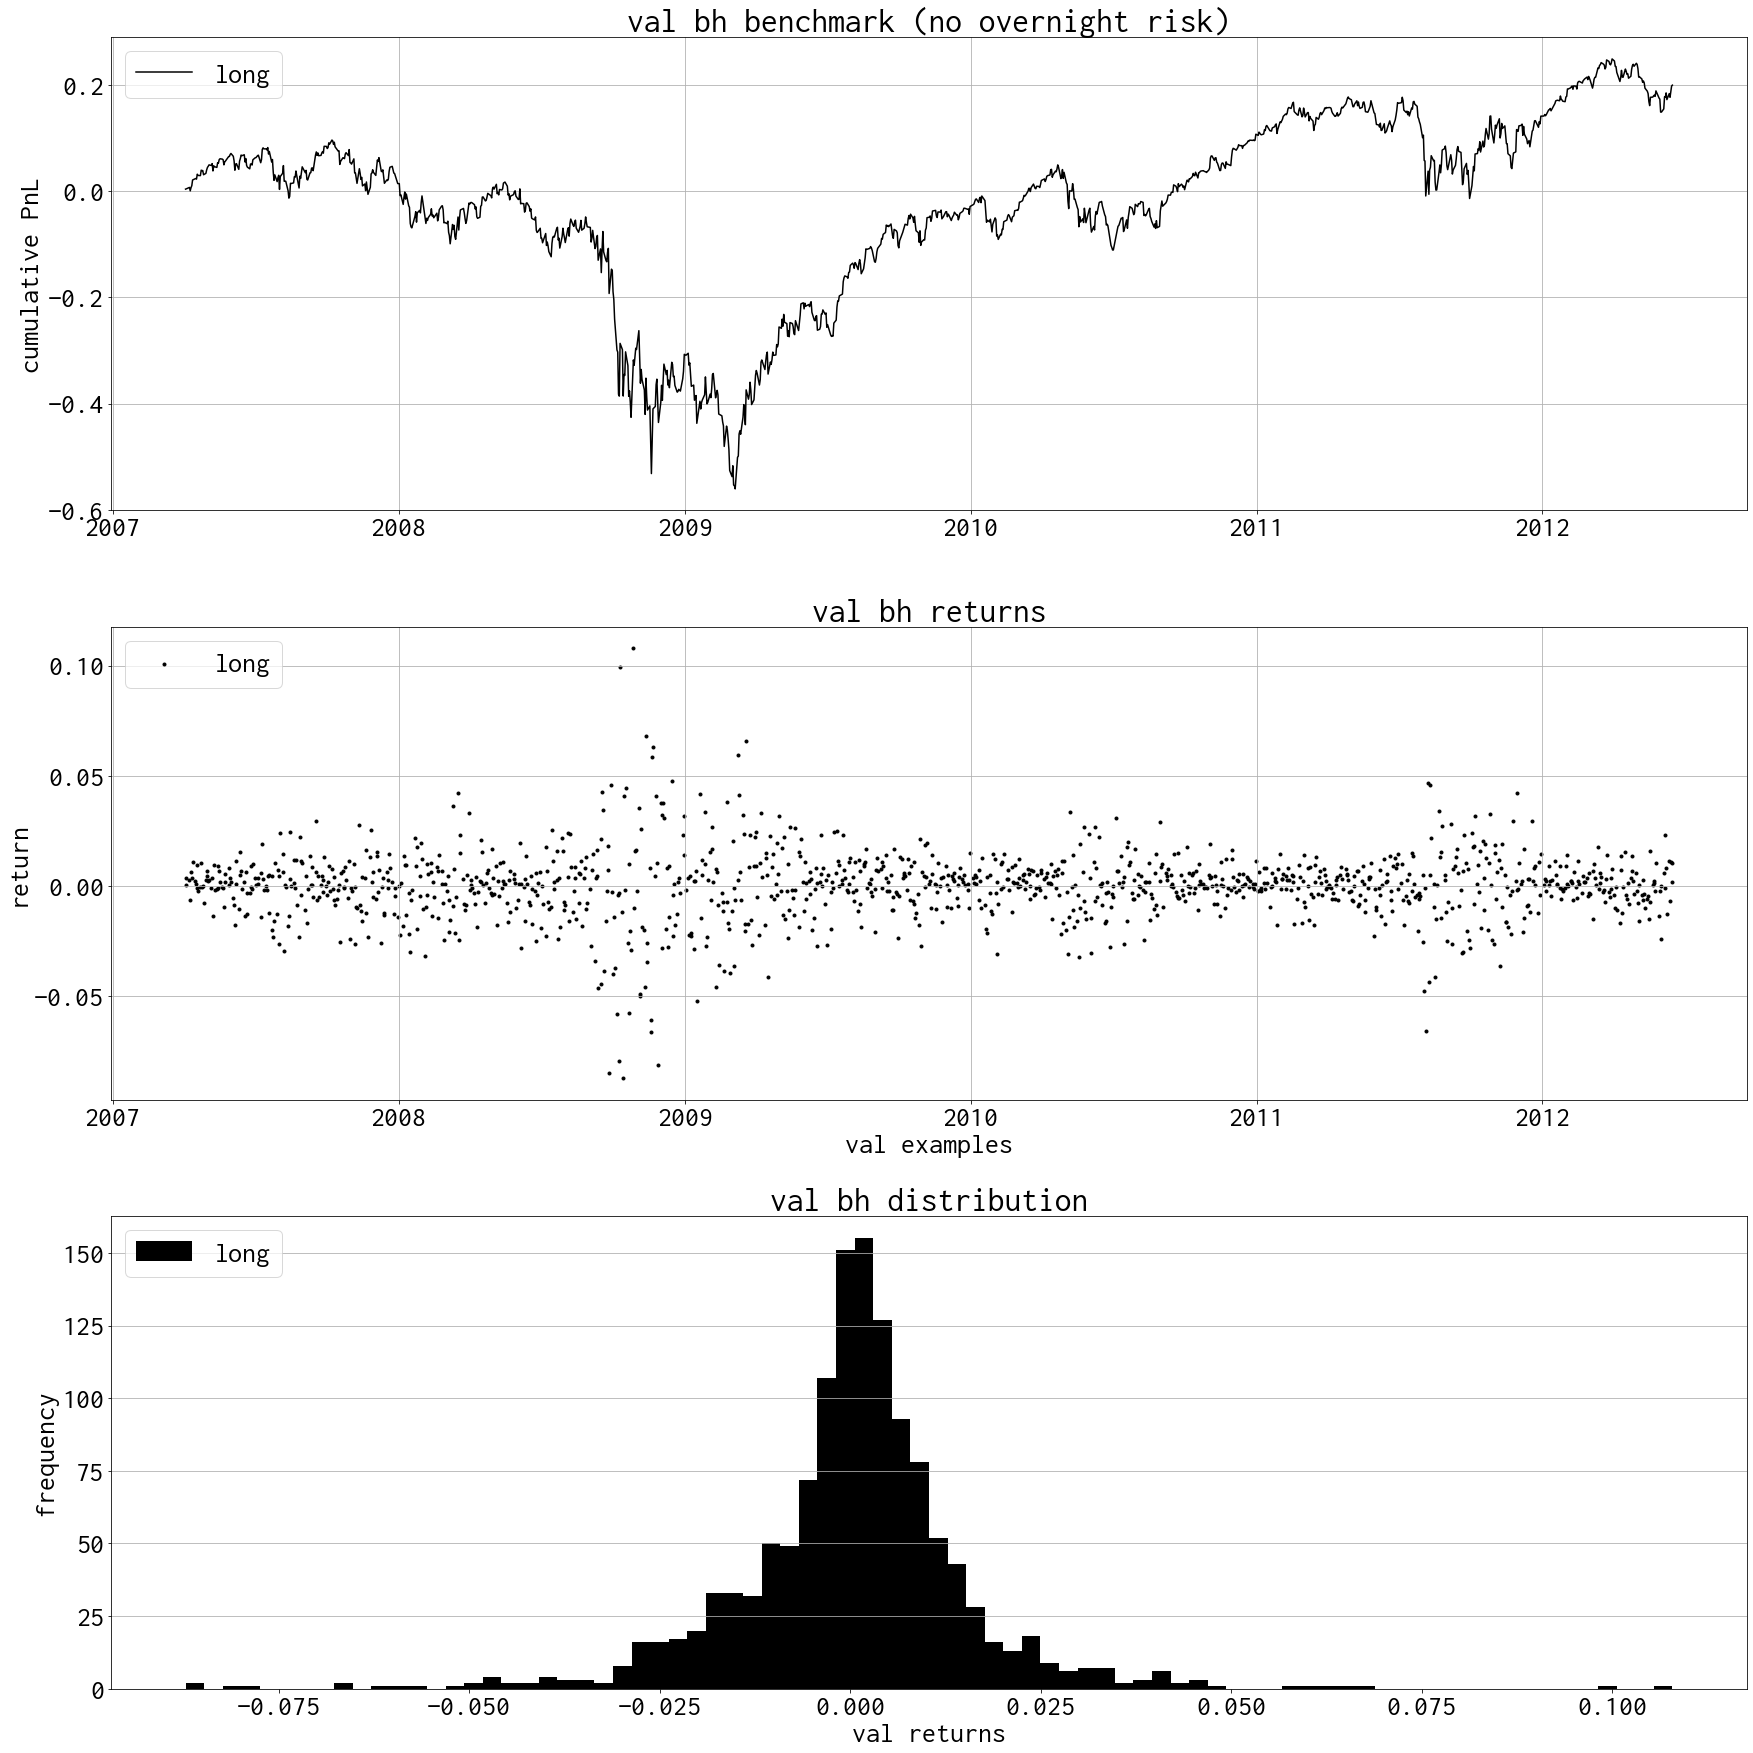

In [96]:
plot_bench_results(bench_strats, "train", "bh")
plt.savefig(trial_dir +"train_bh_long", bbox_inches="tight", transparent=True)

plot_bench_results(bench_strats, "val", "bh")
plt.savefig(trial_dir +"val_bh_long", bbox_inches="tight", transparent=True)

long          0.267593
short         0.394810
long+short    0.021715
dtype: float32
long          0.443920
short         0.619926
long+short    0.147415
dtype: float32


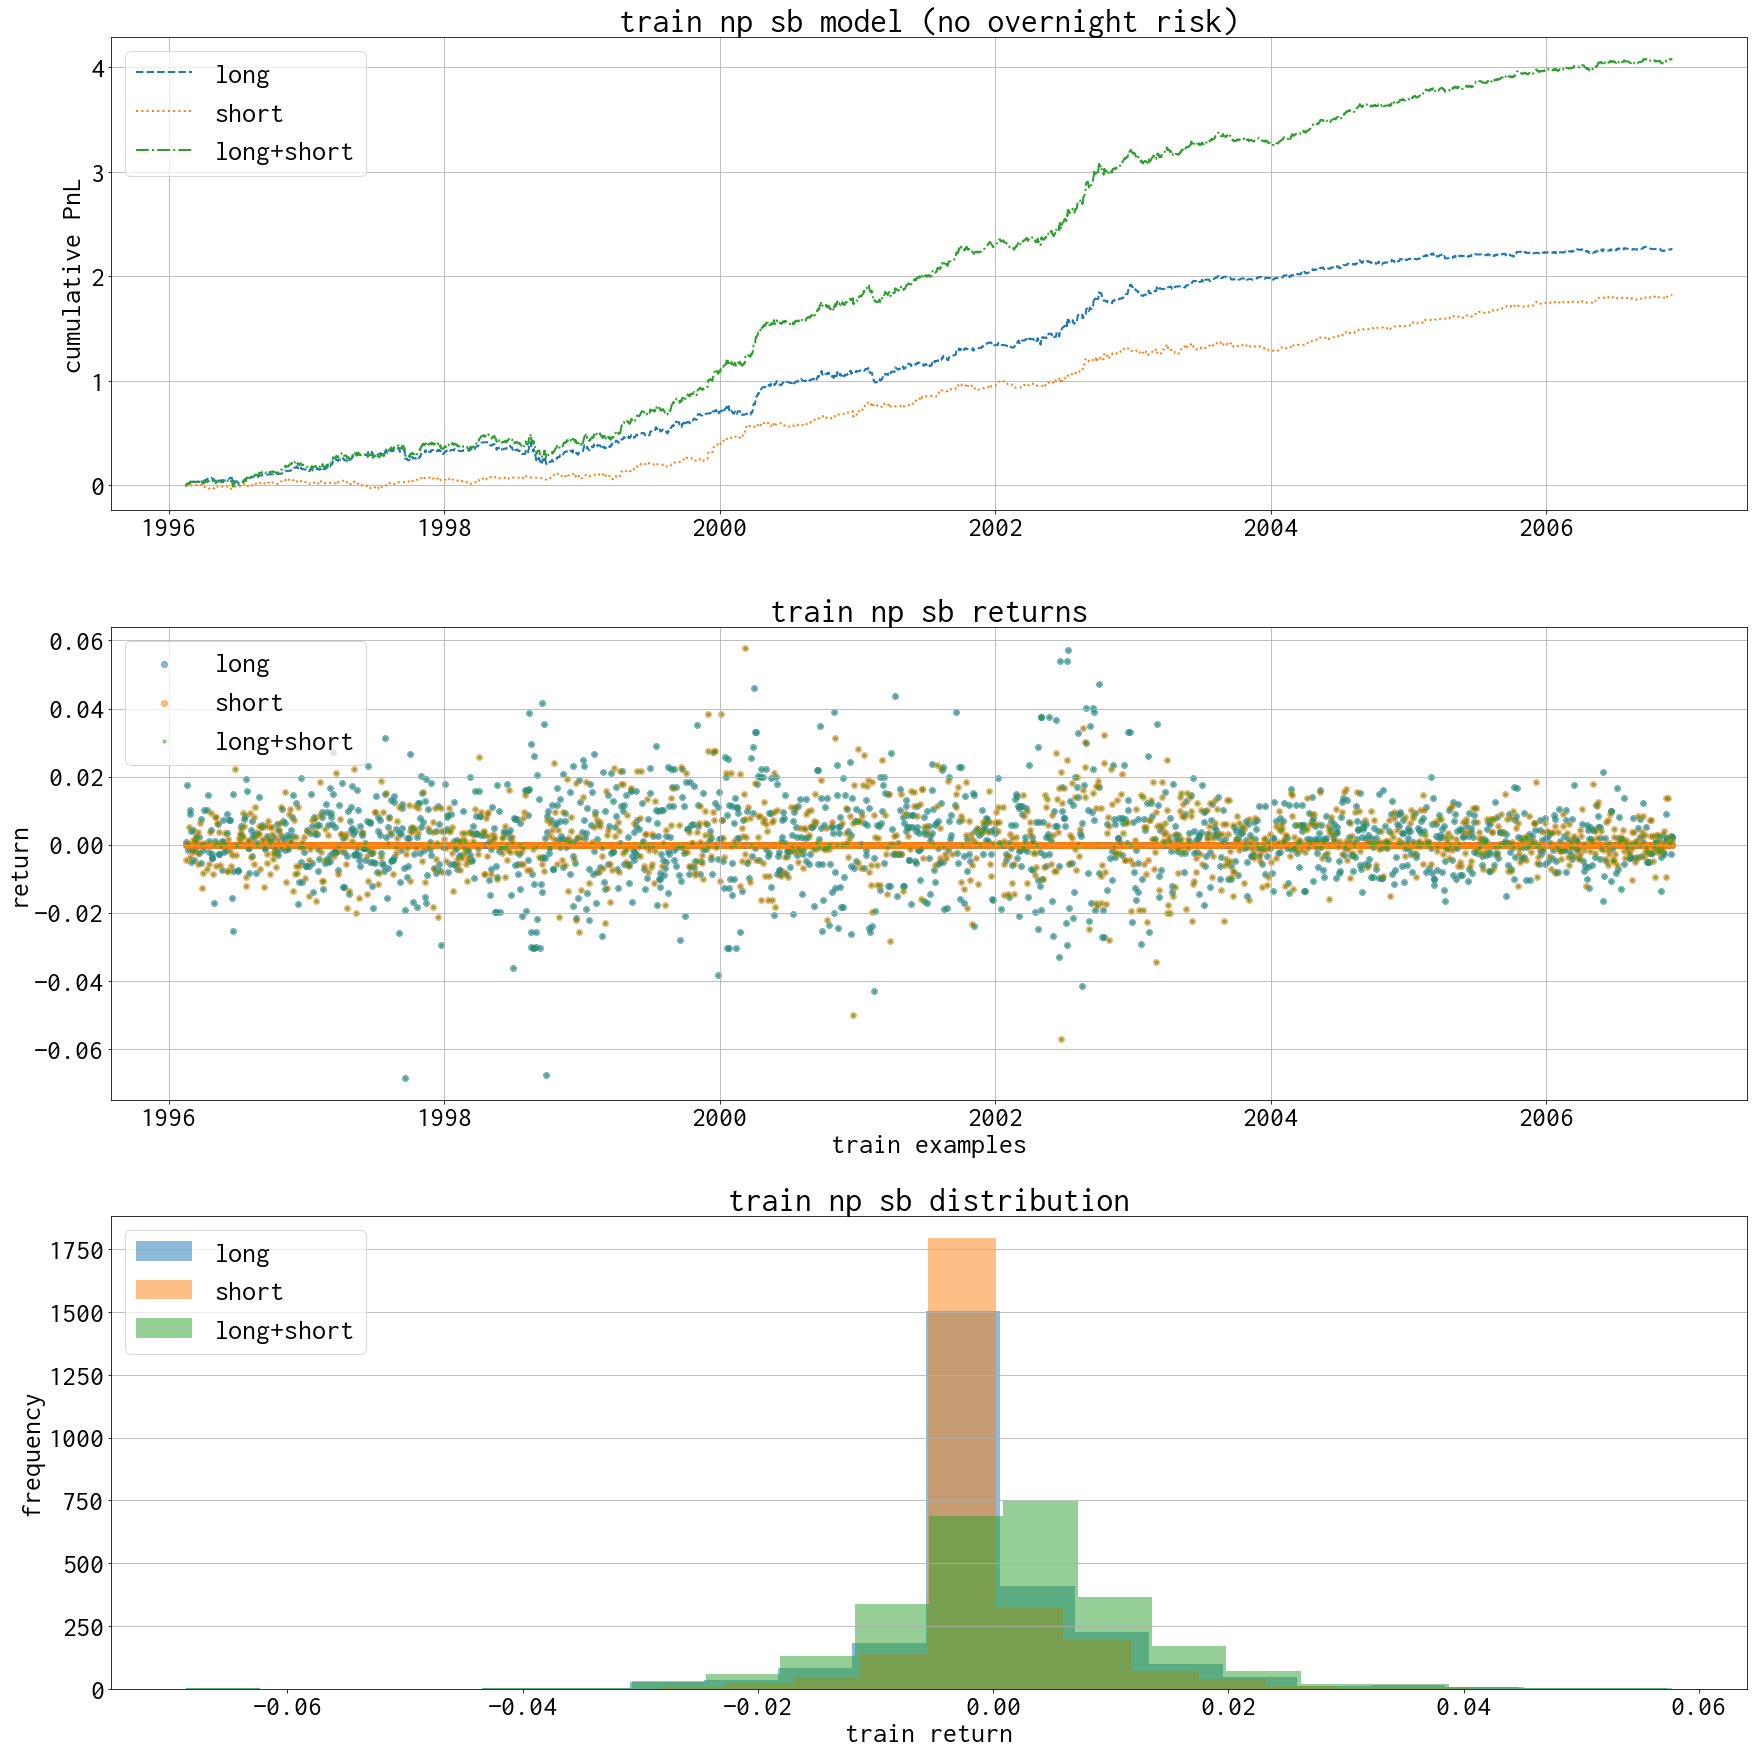

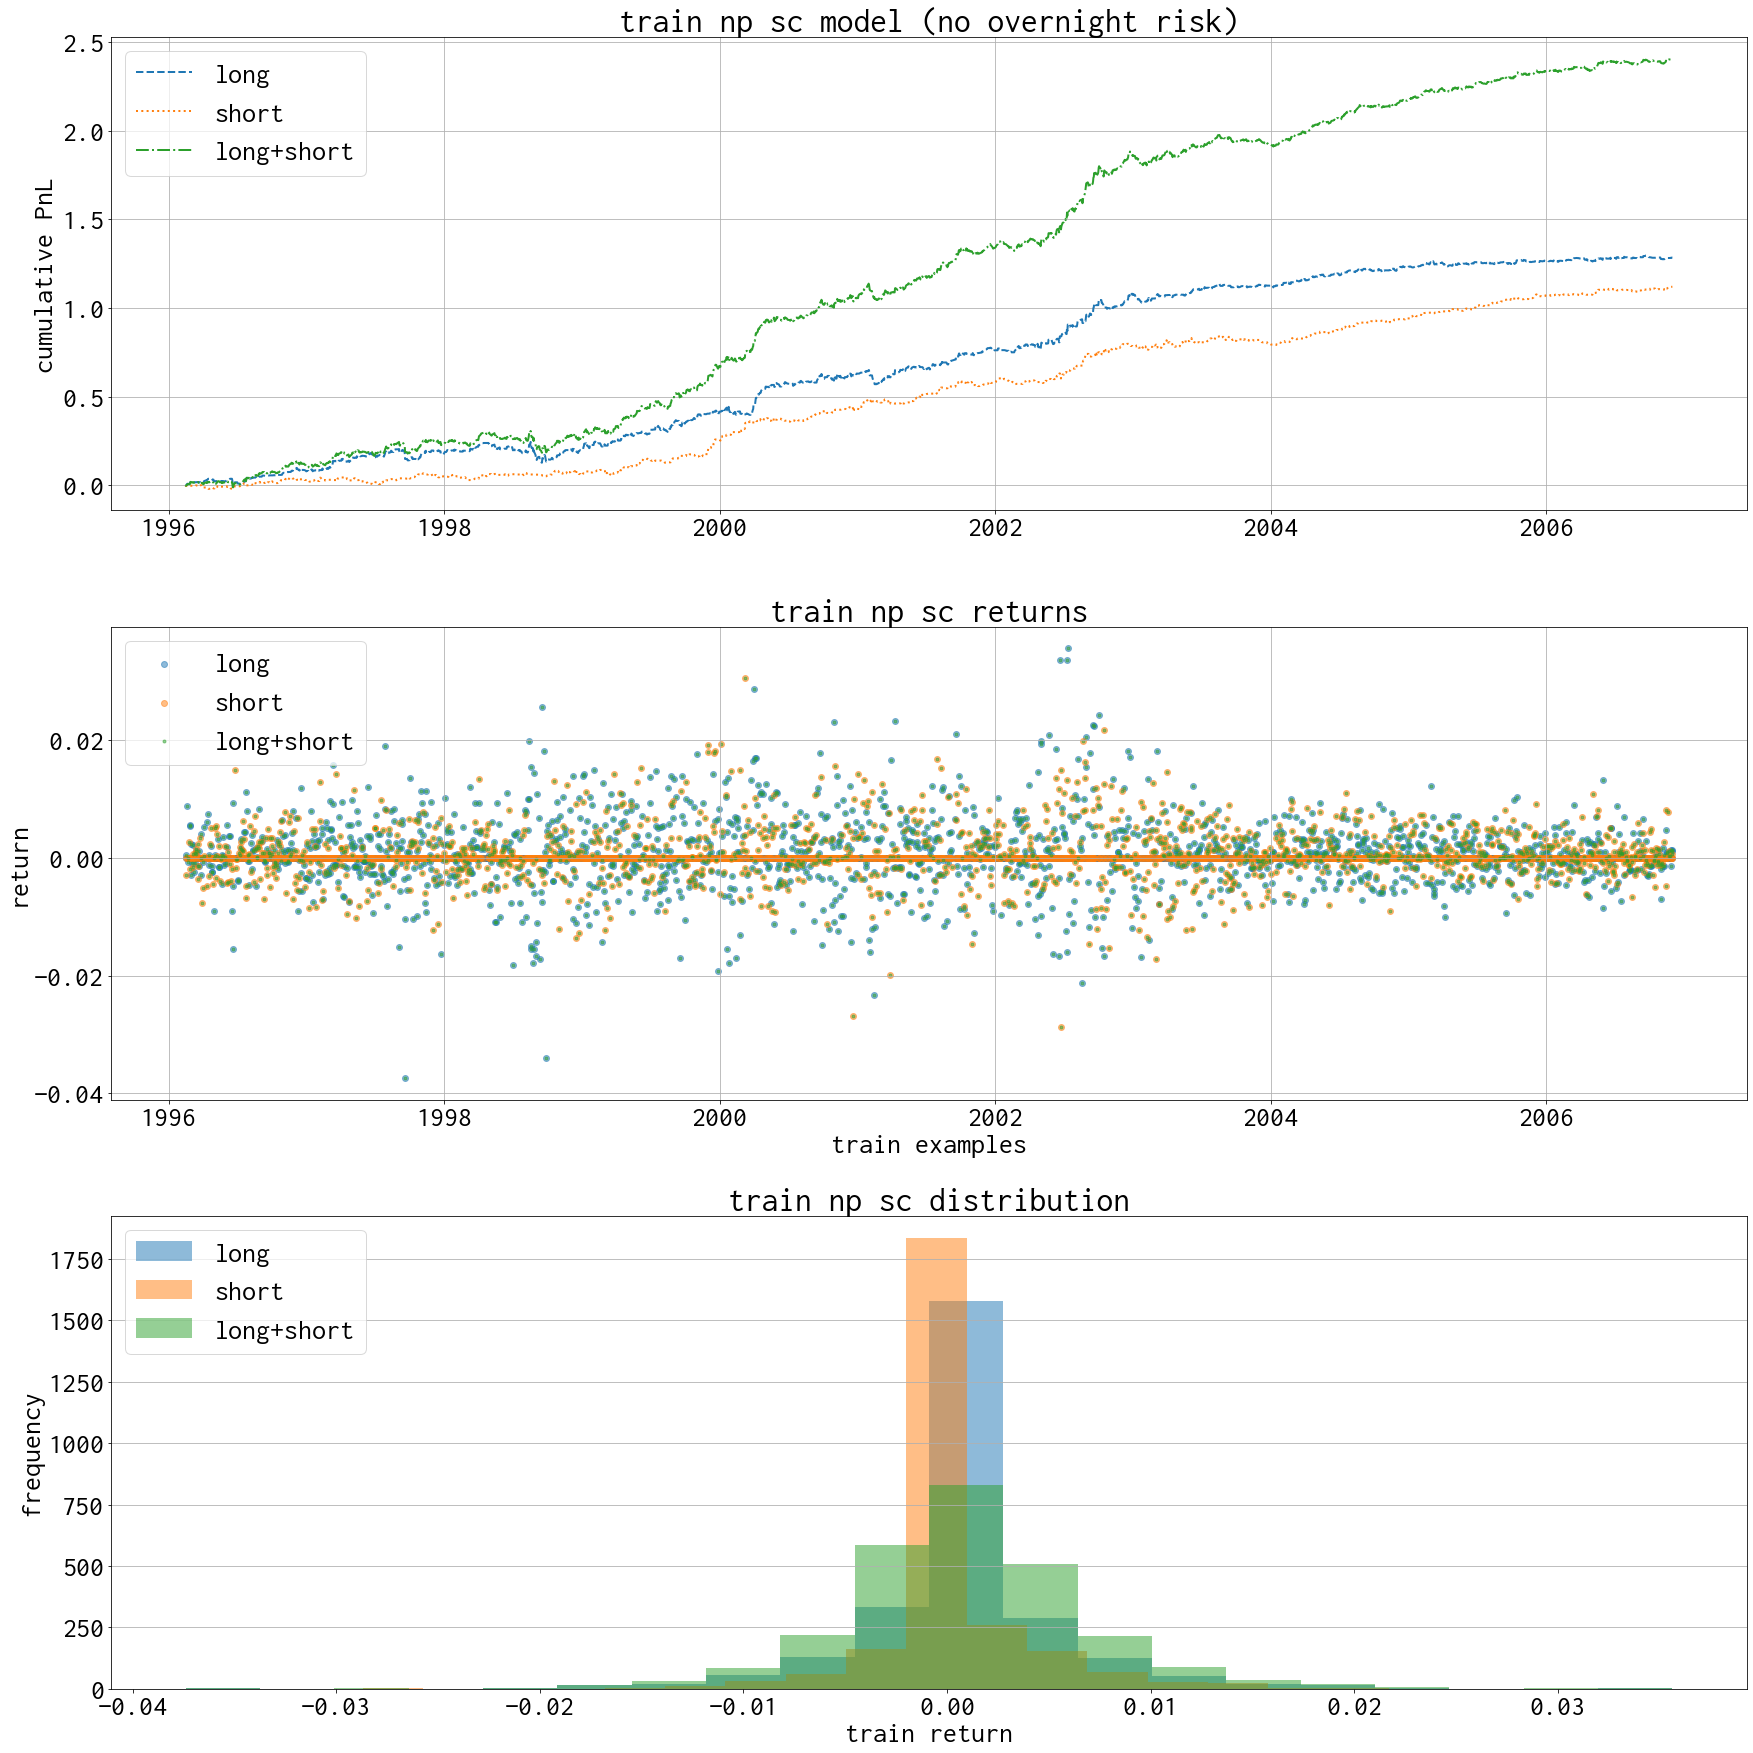

In [97]:
plot_mdl_results(mdl_strats, "train", "sb", np_type)
plt.savefig(trial_dir +"train_sb", bbox_inches="tight", transparent=True)

plot_mdl_results(mdl_strats, "train", "sc", np_type)
plt.savefig(trial_dir +"train_sc", bbox_inches="tight", transparent=True)

long          0.357839
short         2.473546
long+short    0.397276
dtype: float32
long          0.506694
short         2.844336
long+short    0.569291
dtype: float32


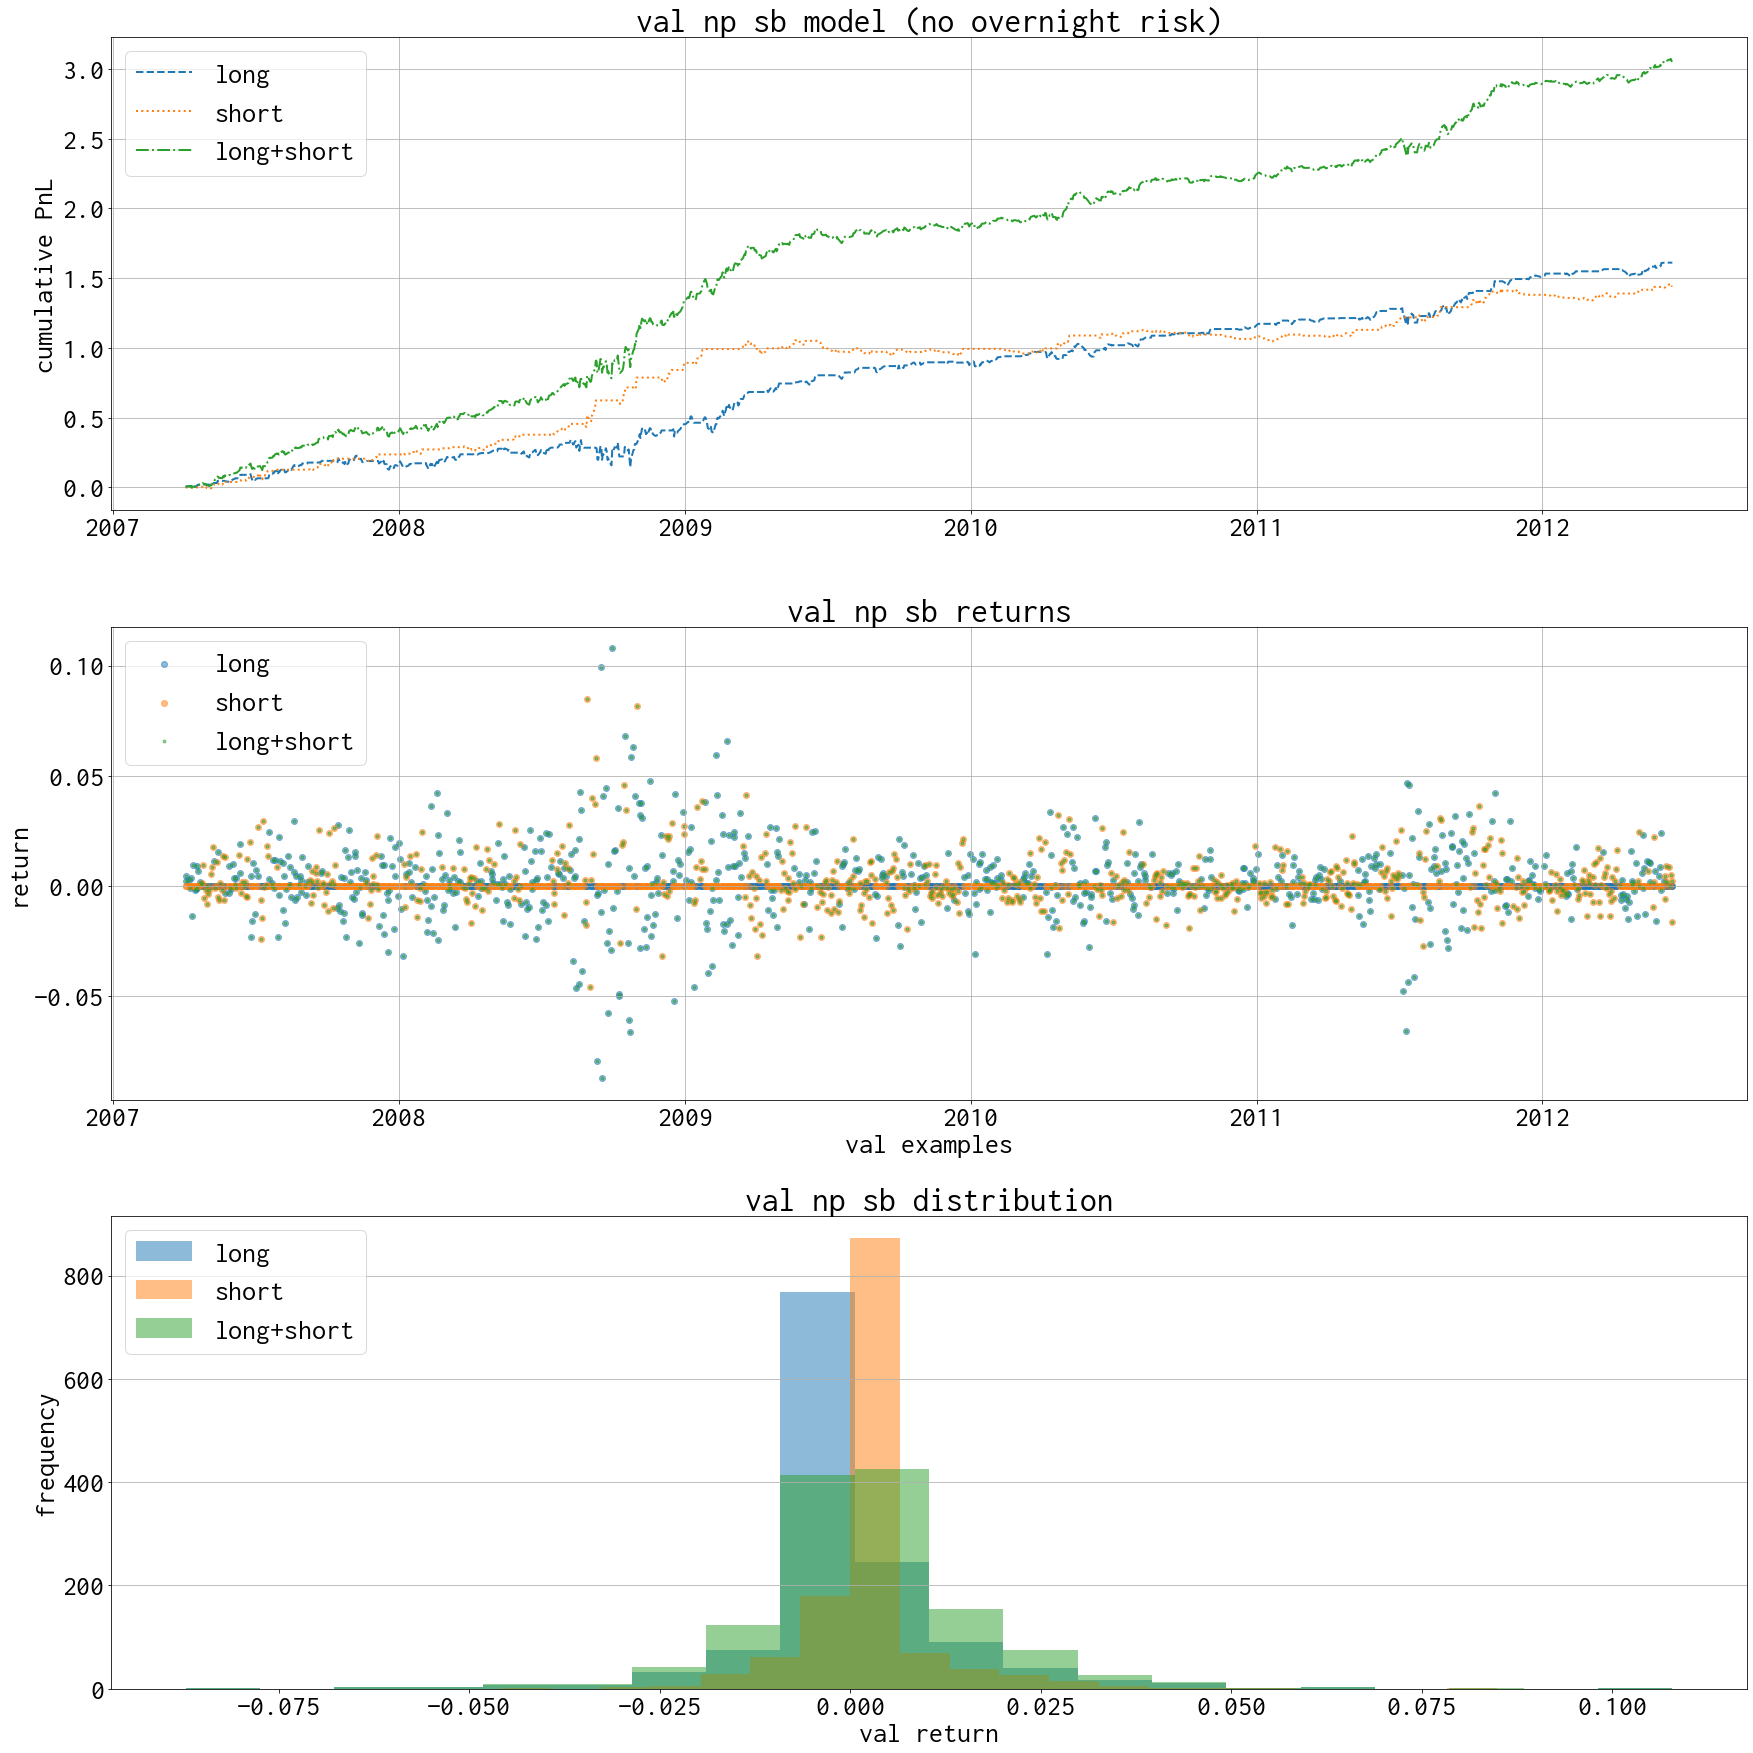

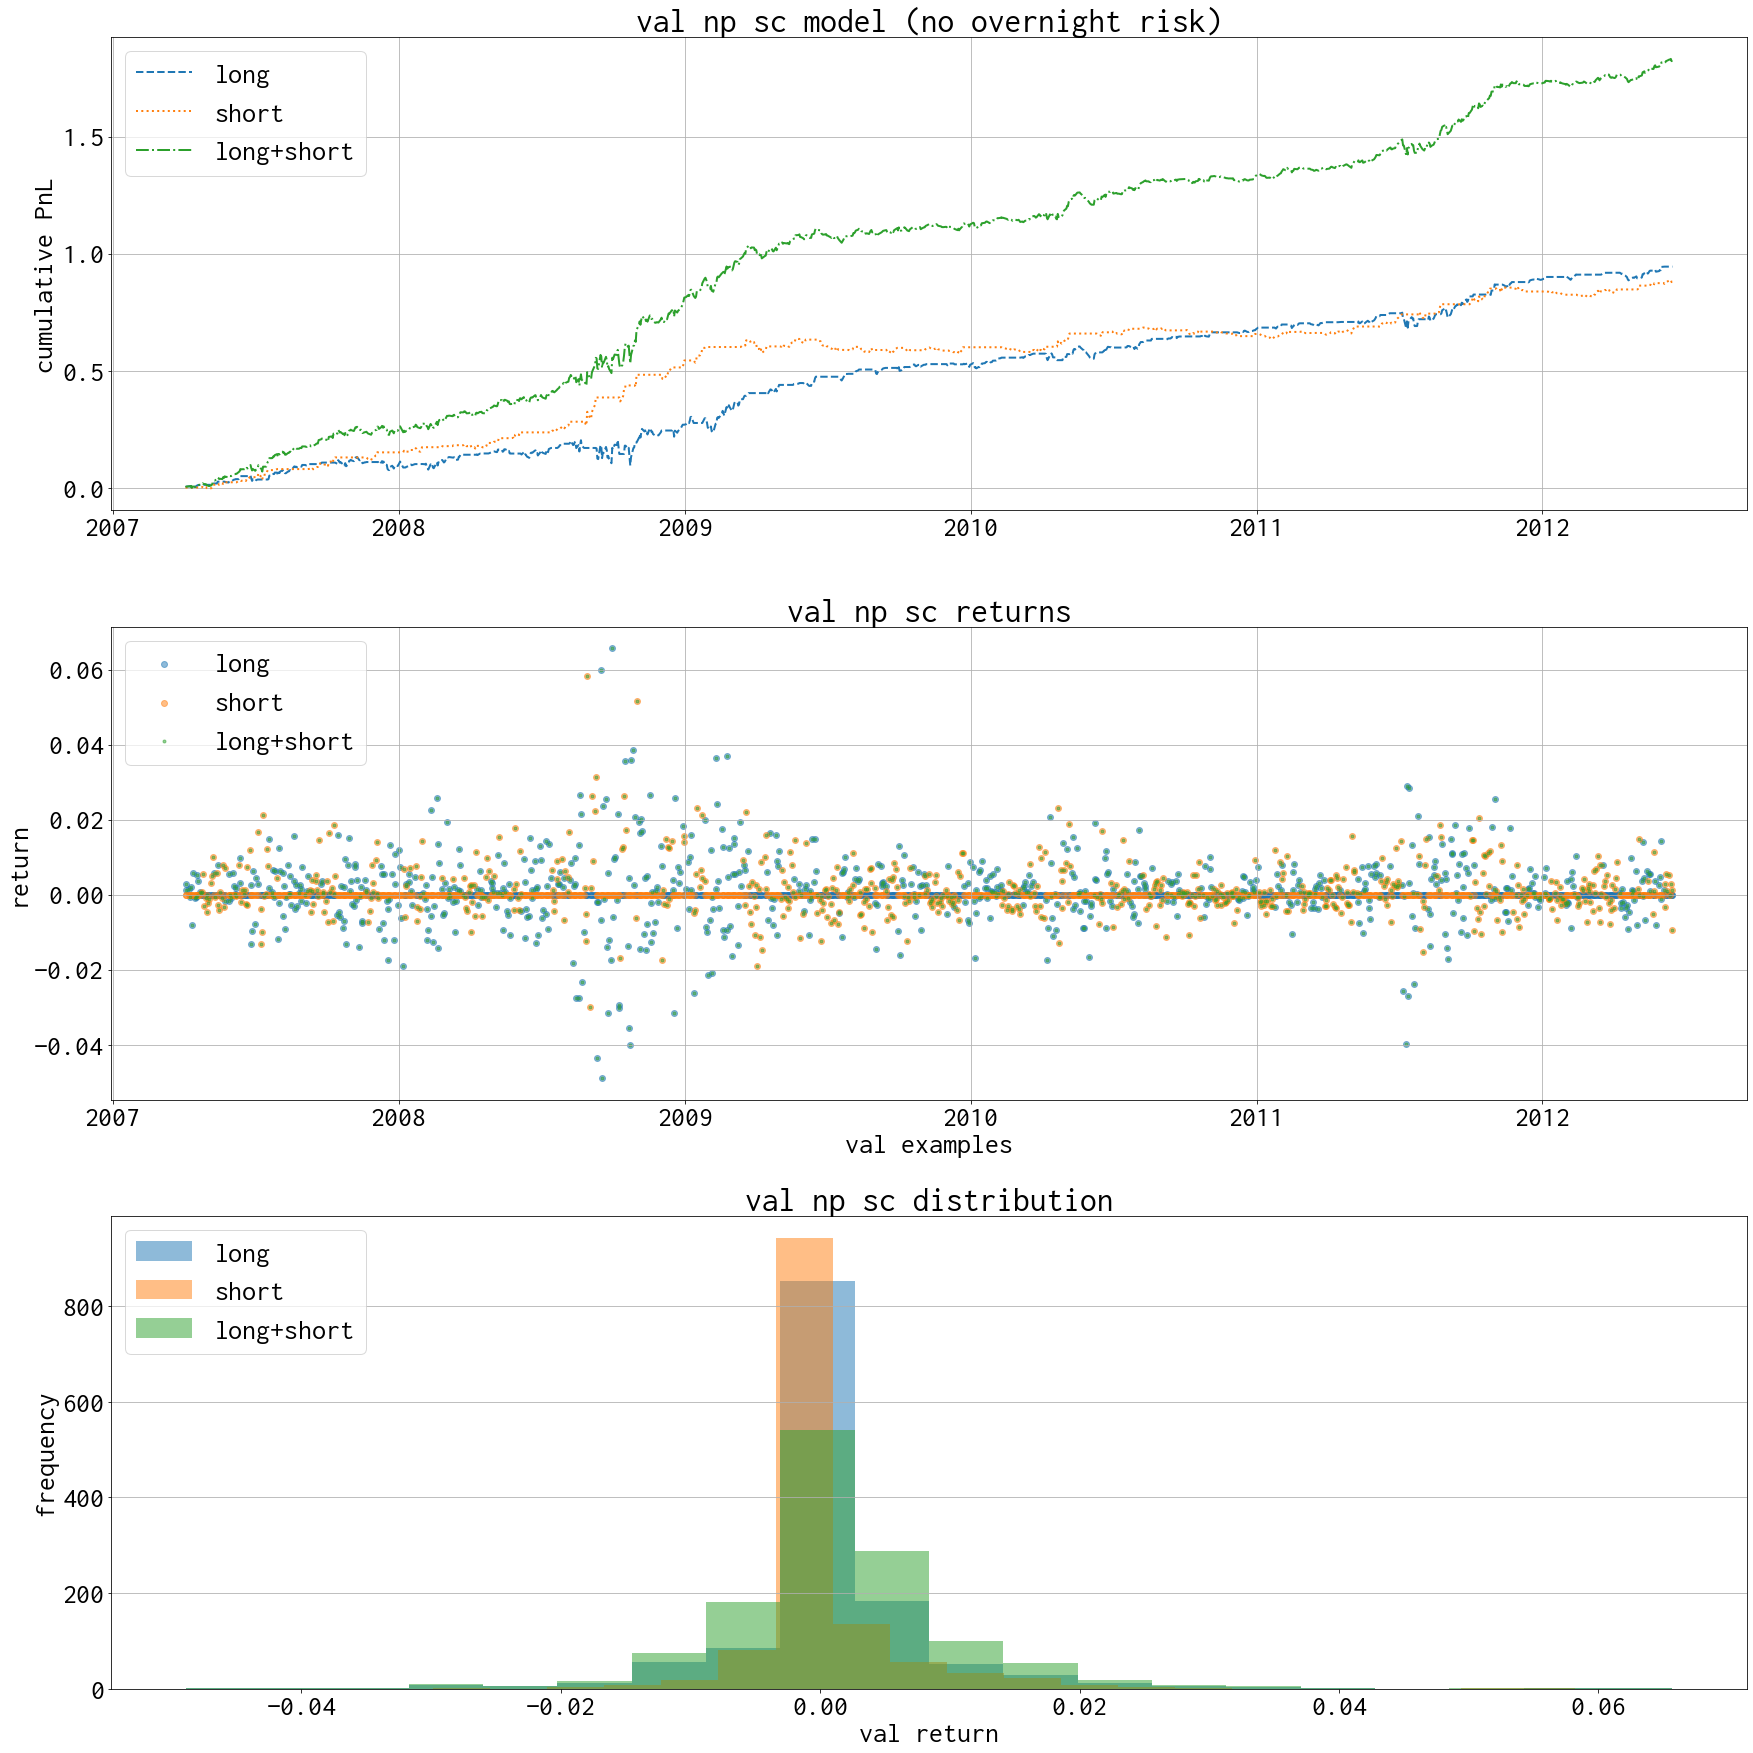

In [98]:
plot_mdl_results(mdl_strats, "val", "sb", np_type)
plt.savefig(trial_dir +"val_sb", bbox_inches="tight", transparent=True)

plot_mdl_results(mdl_strats, "val", "sc", np_type)
plt.savefig(trial_dir +"val_sc", bbox_inches="tight", transparent=True)

# Result Summary

In [ ]:
def loss_graph():
    metrics = load_df('metrics.csv', trial_dir, data_format='csv')
    

In [1]:
bench_res = load_json('benchmark.json', study_dir)
raw_res = load_df('metrics.csv', trial_dir, data_format='csv')
statlen = min_epochs//5
print(f'{statlen=}')
res = []

NameError: name 'load_json' is not defined

In [70]:
split = 'train'
res.append(raw_res[[f'{split}_accuracy', f'{split}_f1.0',
         f'{split}_precision', f'{split}_recall',
         f'{split}_loss',
         f'{split}_br_cumret', f'{split}_cr_cumret', f'{split}_kr_cumret',
         f'{split}_br_sharpe', f'{split}_cr_sharpe', f'{split}_kr_sharpe',
        ]].dropna().iloc[-statlen:].mean().to_dict())

In [71]:
split = 'val'
res.append(raw_res[[f'{split}_accuracy', f'{split}_f1.0',
         f'{split}_precision', f'{split}_recall',
         f'{split}_loss',
         f'{split}_br_cumret', f'{split}_cr_cumret', f'{split}_kr_cumret',
         f'{split}_br_sharpe', f'{split}_cr_sharpe', f'{split}_kr_sharpe',
        ]].dropna().iloc[-statlen:].mean().to_dict())

In [72]:
dump_json(res, 'results', dir_path=trial_dir)

In [321]:
res

NameError: name 'res' is not defined

In [74]:
# raw_res[plot_stats2].dropna().iloc[-statlen:].mean() - bench_res[f'{split2}_bs_{retmet}']

In [75]:
monitor_ser = load_df('metrics.csv', trial_dir, data_format='csv')[monitor].dropna()
monitor_ser[-len(monitor_ser)//10:].mean()

0.553607722123464

## Graphs

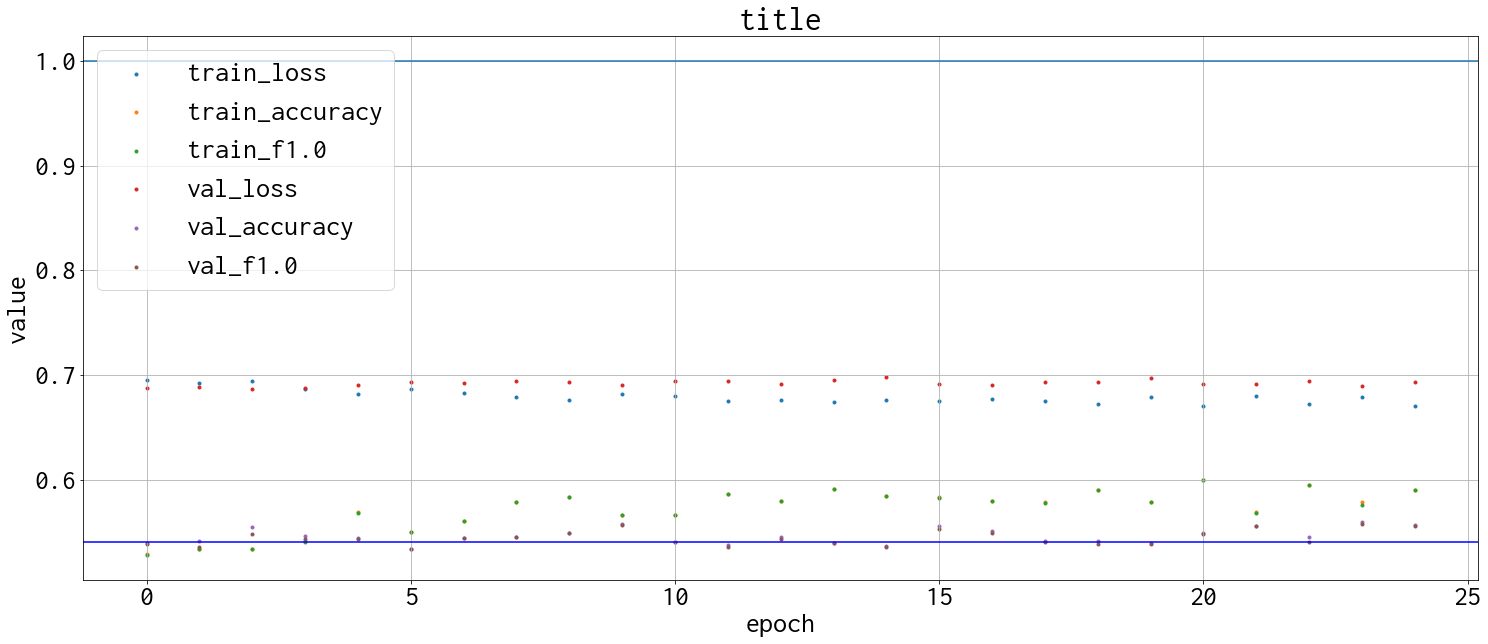

In [76]:
split1 = 'train'
split2 = 'val'
plot_df_scatter(raw_res[[f'{split1}_loss', f'{split1}_accuracy', f'{split1}_f1.0', #f'{split1}_precision', f'{split1}_recall',
                 f'{split2}_loss', f'{split2}_accuracy', f'{split2}_f1.0', #f'{split2}_precision', f'{split2}_recall'
                ]], xlabel='epoch', ylabel='value')
plt.axhline(y=max(freq_count), linestyle='-',  color='b')
plt.axhline(y=1)
plt.grid()
plt.show()

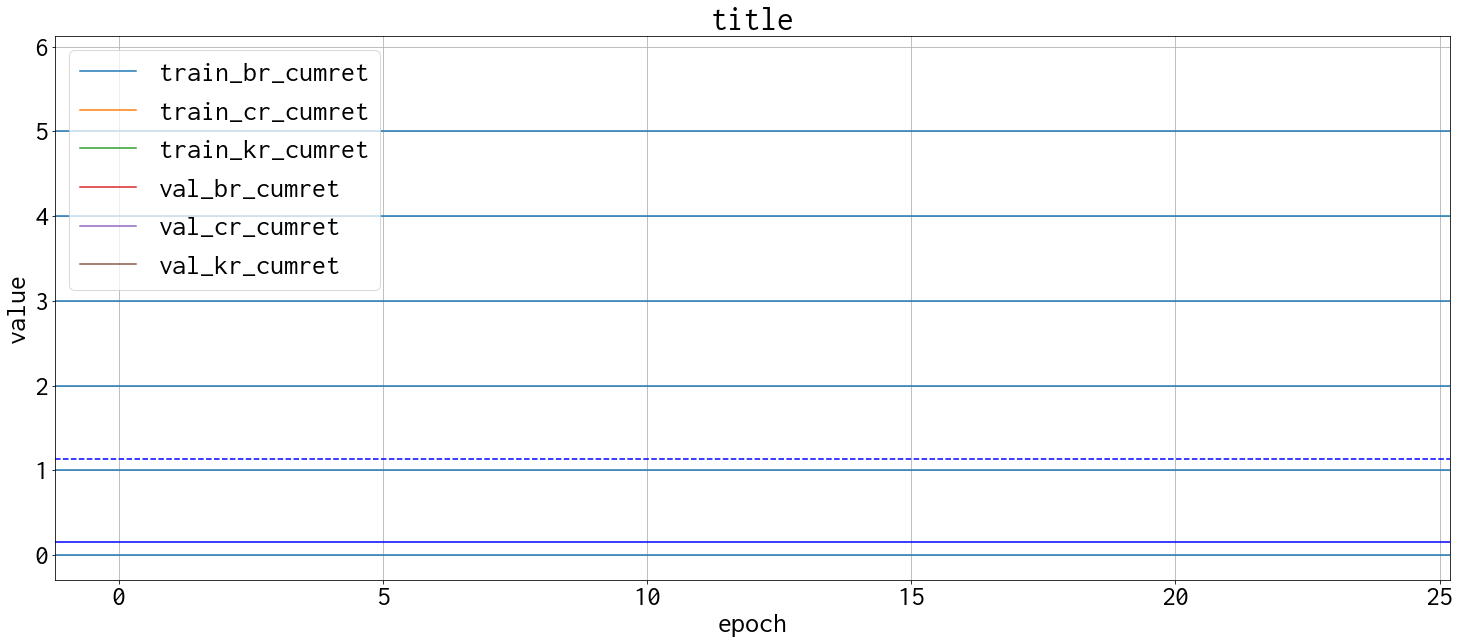

In [77]:
retmet = 'cumret' # cumret, sharpe, min, max
split = split1
plot_stats1 = [f'{split}_br_{retmet}', f'{split}_cr_{retmet}', f'{split}_kr_{retmet}',
#         f'{split}_cr_t(0.050)_{retmet}', f'{split}_cr_t(0.125)_{retmet}', f'{split}_cr_t(0.250)_{retmet}',
#         f'{split}_cr_t(0.500)_{retmet}', f'{split}_cr_t(0.750)_{retmet}',
#         f'{split}_kr_t(0.050)_{retmet}', f'{split}_kr_t(0.125)_{retmet}', f'{split}_kr_t(0.250)_{retmet}',
#         f'{split}_kr_t(0.500)_{retmet}', f'{split}_kr_t(0.750)_{retmet}',
]
split = split2
plot_stats2 = [f'{split}_br_{retmet}', f'{split}_cr_{retmet}', f'{split}_kr_{retmet}',
#         f'{split}_cr_t(0.050)_{retmet}', f'{split}_cr_t(0.125)_{retmet}', f'{split}_cr_t(0.250)_{retmet}',
#         f'{split}_cr_t(0.500)_{retmet}', f'{split}_cr_t(0.750)_{retmet}',
#         f'{split}_kr_t(0.050)_{retmet}', f'{split}_kr_t(0.125)_{retmet}', f'{split}_kr_t(0.250)_{retmet}',
#         f'{split}_kr_t(0.500)_{retmet}', f'{split}_kr_t(0.750)_{retmet}',
]
plot_df_line(raw_res[[*plot_stats1, *plot_stats2]], xlabel='epoch', ylabel='value')
plt.axhline(y=bench_res[f'{split1}_bs_{retmet}'], linestyle='--', color='b')
# plt.axhline(y=bench_res[f'{split1}_os_{retmet}'], linestyle='--', color='c')
plt.axhline(y=bench_res[f'{split2}_bs_{retmet}'], linestyle='-',  color='b')
# plt.axhline(y=bench_res[f'{split2}_os_{retmet}'], linestyle='-',  color='c')
plt.axhline(y=0)
plt.axhline(y=1)
plt.axhline(y=2)
plt.axhline(y=3)
plt.axhline(y=4)
plt.axhline(y=5)
plt.grid()
plt.show()

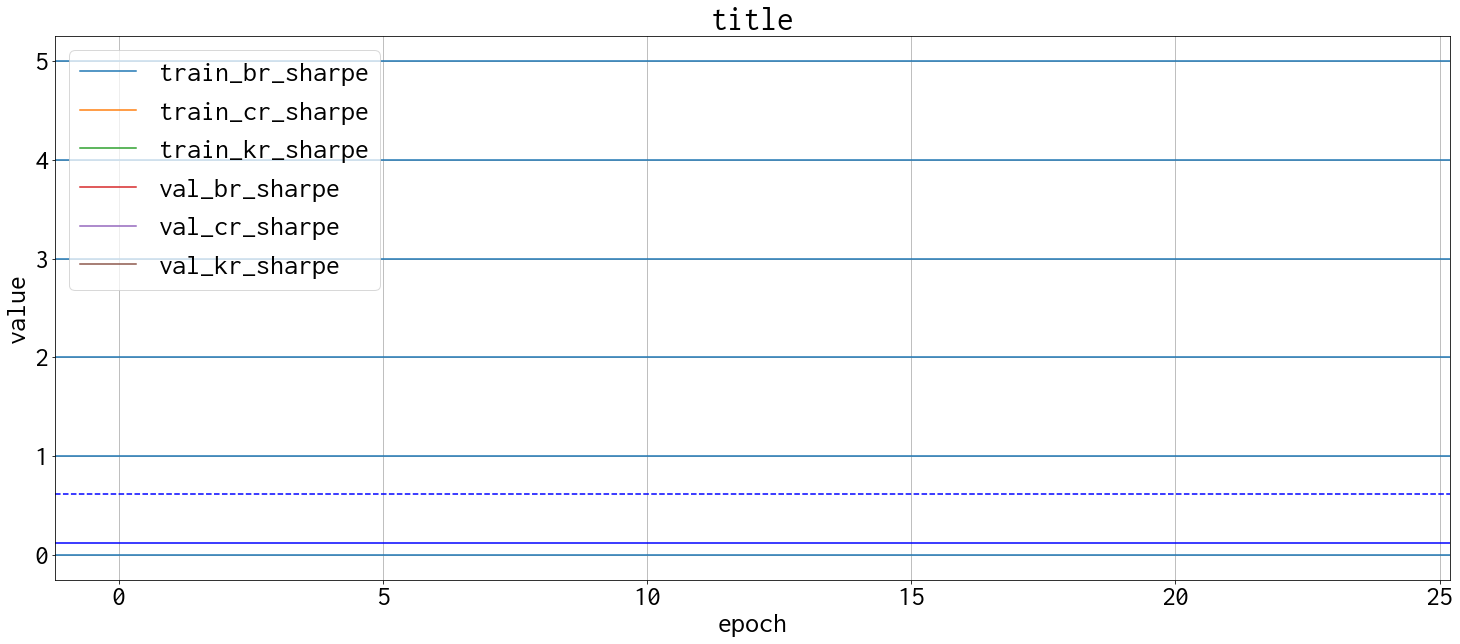

In [78]:
split1 = 'train'
split2 = 'val'
retmet = 'sharpe'
split = split1
plot_stats1 = [f'{split}_br_{retmet}', f'{split}_cr_{retmet}', f'{split}_kr_{retmet}',
#         f'{split}_cr_t(0.050)_{retmet}', f'{split}_cr_t(0.125)_{retmet}', f'{split}_cr_t(0.250)_{retmet}',
#         f'{split}_cr_t(0.500)_{retmet}', f'{split}_cr_t(0.750)_{retmet}',
#         f'{split}_kr_t(0.050)_{retmet}', f'{split}_kr_t(0.125)_{retmet}', f'{split}_kr_t(0.250)_{retmet}',
#         f'{split}_kr_t(0.500)_{retmet}', f'{split}_kr_t(0.750)_{retmet}',
]
split = split2
plot_stats2 = [f'{split}_br_{retmet}', f'{split}_cr_{retmet}', f'{split}_kr_{retmet}',
#         f'{split}_cr_t(0.050)_{retmet}', f'{split}_cr_t(0.125)_{retmet}', f'{split}_cr_t(0.250)_{retmet}',
#         f'{split}_cr_t(0.500)_{retmet}', f'{split}_cr_t(0.750)_{retmet}',
#         f'{split}_kr_t(0.050)_{retmet}', f'{split}_kr_t(0.125)_{retmet}', f'{split}_kr_tKNN(0.250)_{retmet}',
#         f'{split}_kr_t(0.500)_{retmet}', f'{split}_kr_t(0.750)_{retmet}',
]
plot_df_line(raw_res[[*plot_stats1, *plot_stats2]], xlabel='epoch', ylabel='value')
plt.axhline(y=bench_res[f'{split1}_bs_{retmet}'], linestyle='--', color='b')
# plt.axhline(y=bench_res[f'{split1}_os_{retmet}'], linestyle='--', color='c')
plt.axhline(y=bench_res[f'{split2}_bs_{retmet}'], linestyle='-',  color='b')
# plt.axhline(y=bench_res[f'{split2}_os_{retmet}'], linestyle='-',  color='c')
plt.axhline(y=0)
plt.axhline(y=1)
plt.axhline(y=2)
plt.axhline(y=3)
plt.axhline(y=4)
plt.axhline(y=5)
plt.grid()
plt.show()